Backtrader Pairs trading example: https://nbviewer.org/github/polakowo/vectorbt/blob/master/examples/PairsTrading.ipynb

Pairs trading example: https://github.com/paperswithbacktest/awesome-systematic-trading/blob/main/static/strategies/pairs-trading-with-stocks

Statistical Arbitrage via Single-View and Multi-View Spectral Clustering on Mixed Frequency Data: https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4975855 

PCA Statistical Arbitrage:
1. https://github.com/rodler/quantinsti_statarb/blob/master/PCA_StatArb.ipynb
2. https://github.com/rodler/quantinsti_statarb/blob/master/PCA_2.ipynb
3. https://github.com/rodler/quantinsti_statarb/blob/master/PCA_3.ipynb

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import coint, adfuller
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
import itertools
import matplotlib.pyplot as plt
from datetime import datetime

In [ ]:
etfs = [
    'SPY', 'VOO', 'IVV', 'VTI', 'QQQ', 'VUG', 'VTV', 'IEFA', 'VEA', 'VWO', 'IEMG',
    'XLK', 'VGT', 'DAGB', 'DFNG',
    'GLD', 'SLV', 'USO', 'DBA',
    'AGG', 'BND', 'TLT',
    'AOA', 'AOR', 'AOM'
]
commodities = [
    'CL=F',  # WTI Crude Oil
    'BZ=F',  # Brent Crude Oil
    'NG=F',  # Natural Gas
    'GC=F',  # Gold
    'SI=F',  # Silver
    'PL=F',  # Platinum
    'PA=F',  # Palladium
    'HG=F',  # Copper
    'ZC=F',  # Corn
    'ZW=F',  # Wheat
    'ZS=F',  # Soybeans
    'ZO=F',  # Oats
    'KC=F',  # Coffee
    'SB=F',  # Sugar
    'CT=F',  # Cotton
    'CC=F',  # Cocoa
    'LE=F',  # Live Cattle
    'GF=F',  # Feeder Cattle
    'HE=F',  # Lean Hogs
]

global_indexes = ['^DJI', '^IXIC', '^GSPC', '^FTSE', '^N225', '^HSI', '^AXJO', '^KS11', '^BFX', '^N100',
                  '^RUT', '^VIX', '^TNX']

In [ ]:
forex_pairs = [
    # Major Currency Pairs
    'EURUSD=X', 'GBPUSD=X', 'AUDUSD=X', 'NZDUSD=X', 'USDJPY=X', 'USDCHF=X', 'USDCAD=X',
    'EURJPY=X', 'GBPJPY=X', 'EURGBP=X', 'EURCHF=X',

    # Minor Currency Pairs
    'EURAUD=X', 'EURCAD=X', 'EURNZD=X', 'GBPCHF=X', 'GBPAUD=X', 'GBPCAD=X', 'GBPNZD=X',
    'CHFJPY=X', 'AUDJPY=X', 'CADJPY=X', 'NZDJPY=X', 'AUDNZD=X', 'AUDCHF=X', 'AUDCAD=X',
    'CADCHF=X', 'NZDCHF=X', 'SGDJPY=X', 'SEKJPY=X', 'NOKJPY=X', 'DKKJPY=X', 'ZARJPY=X',

    # Exotic/Emerging Market Pairs
    'USDSEK=X', 'USDNOK=X', 'USDDKK=X', 'USDSGD=X', 'USDHKD=X', 'EURHUF=X', 'EURPLN=X',
    'EURCZK=X', 'EURTRY=X', 'EURSEK=X', 'GBPSEK=X', 'GBPNOK=X', 'GBPDKK=X', 'GBPSGD=X',
    'GBPHKD=X', 'CNY=X', 'HKD=X', 'IDR=X', 'INR=X', 'MYR=X', 'PHP=X', 'RUB=X',
    'SGD=X', 'THB=X', 'MXN=X', 'ZAR=X'
]

def download_forex_data(pairs, start_date, end_date):
    """
    Download forex data from Yahoo Finance
    """
    try:
        data = yf.download(pairs, start=start_date, end=end_date, interval='1d')['Close']
        # Remove pairs with too many missing values
        missing_threshold = len(data) * 0.05  # 5% missing data threshold
        data = data.ffill()
        data = data.dropna(axis=1, thresh=missing_threshold)
        return data
    except Exception as e:
        print(f"Error downloading data: {e}")
        return None

In [79]:
def test_cointegration(pair1, pair2, data, significance_level=0.05):
    """
    Test for cointegration between two forex pairs
    Returns: (is_cointegrated, p_value, hedge_ratio, half_life)
    """
    try:
        y = data[pair1]
        x = data[pair2]

        # Calculate the optimal hedge ratio (beta) using OLS
        X = sm.add_constant(x)  # Add a constant term to the regression
        model = sm.OLS(y, X)
        results = model.fit()
        beta = results.params.values[1]

        # Calculate the spread
        spread = y - (x * beta) 
        spread.name = f"{pair1} - ({beta:.2f}*{pair2})"

        # Perform ADF test
        result = adfuller(spread.dropna())
        p_value = result[1]

        # Calculate half-life of mean reversion
        spread_lag = spread.shift(1)
        spread_diff = spread - spread_lag
        spread_lag = spread_lag.dropna()
        spread_diff = spread_diff.dropna()

        # Linear Regression for Ornstein-Uhlenbeck process ΔS(t) = α(μ - S(t-1)) + ε(t)
        model = np.polyfit(spread_lag, spread_diff, 1)
        # model[0] = α represents the speed of mean reversion
        half_life = -np.log(2) / model[0] if model[0] < 0 else np.inf 

        return (p_value < significance_level, p_value, beta, half_life)
    except Exception as e:
        print(f"Error in cointegration test for {pair1} and {pair2}: {e}")
        return (False, 1.0, 0, np.inf)

Half-life represents the time taken for the spread to revert halfway to its mean \
Shorter half-life = faster mean reversion = potentially better pairs trading opportunity

1. If half-life = 5 days: spread takes 5 days to move halfway back to its mean
2. If half-life = 20 days: spread takes longer to revert, might be less suitable for trading
3. If half-life = inf: no mean reversion detected

In [73]:
def find_significant_pairs(data, significance_level=0.05):
    """
    Find significantly cointegrated pairs and sort by p-value
    """
    pairs = list(itertools.combinations(data.columns, 2))
    significant_pairs = []

    print(f"\nAnalyzing {len(pairs)} possible pairs...")

    for pair in pairs:
        pair1, pair2 = pair
        is_cointegrated, p_value, hedge_ratio, half_life = test_cointegration(
            pair1, pair2, data, significance_level
        )

        if is_cointegrated and half_life != np.inf and half_life > 0:
            significant_pairs.append({
                'pair1': pair1.replace('=X', ''),
                'pair2': pair2.replace('=X', ''),
                'p_value': p_value,
                'hedge_ratio': hedge_ratio,
                'half_life': half_life
            })

    # Sort by p-value (strongest cointegration first)
    return sorted(significant_pairs, key=lambda x: x['p_value'])

In [84]:
def plot_pair_analysis(data, pair_info):
    """
    Create detailed analysis plot for a pair
    """
    pair1 = pair_info['pair1'] + '=X'
    pair2 = pair_info['pair2'] + '=X'
    hedge_ratio = pair_info['hedge_ratio']

    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 12))

    # Plot 1: Normalized prices
    norm1 = data[pair1] / data[pair1].iloc[0]
    norm2 = data[pair2] / data[pair2].iloc[0]
    ax1.plot(norm1, label=pair_info['pair1'], linewidth=1)
    ax1.plot(norm2, label=pair_info['pair2'], linewidth=1)
    ax1.set_title(f'Normalized Prices: {pair_info["pair1"]} vs {pair_info["pair2"]}')
    ax1.legend()
    ax1.grid(True)

    # Plot 2: Spread
    spread = data[pair1] - hedge_ratio * data[pair2]
    ax2.plot(spread, label='Spread', color='green', linewidth=1)
    ax2.axhline(y=spread.mean(), color='r', linestyle='--', label='Mean')
    ax2.axhline(y=spread.mean() + 2*spread.std(), color='blue', linestyle=':', label='+2σ')
    ax2.axhline(y=spread.mean() - 2*spread.std(), color='blue', linestyle=':', label='-2σ')
    ax2.set_title('Price Spread with Trading Bands')
    ax2.legend()
    ax2.grid(True)

    # Plot 3: Spread distribution
    ax3.hist(spread, bins=50, density=True, alpha=0.7, color='green')
    ax3.set_title('Spread Distribution')
    ax3.grid(True)

    plt.tight_layout()
    return fig

Analyzing forex pairs from 2023-01-01 to 2025-04-08


[*********************100%***********************]  47 of 47 completed



Analyzing 1081 possible pairs...

Found 245 significant pairs (p < 0.05):

Top Cointegrated Pairs:
Pair 1     Pair 2     P-Value    Hedge Ratio  Half-Life 
------------------------------------------------------------
GBPDKK     USDHKD     0.0001    -5.8219      11.0


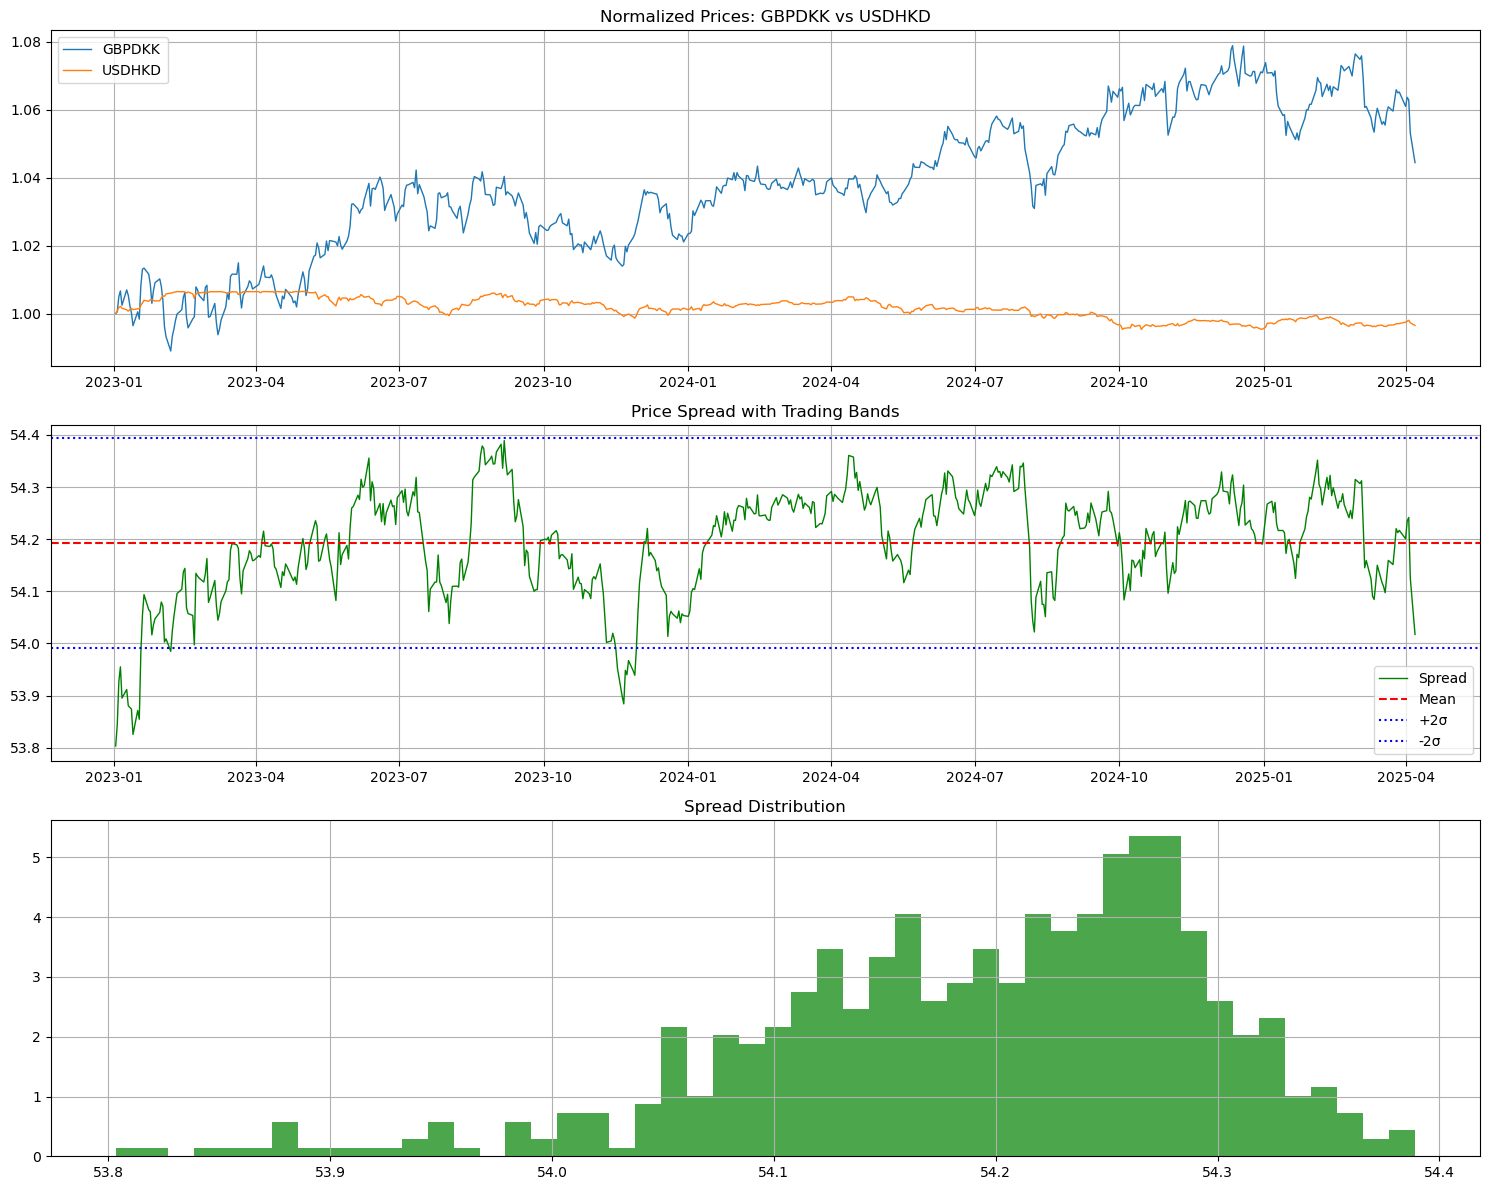

EURGBP     USDHKD     0.0001    0.5537      11.1


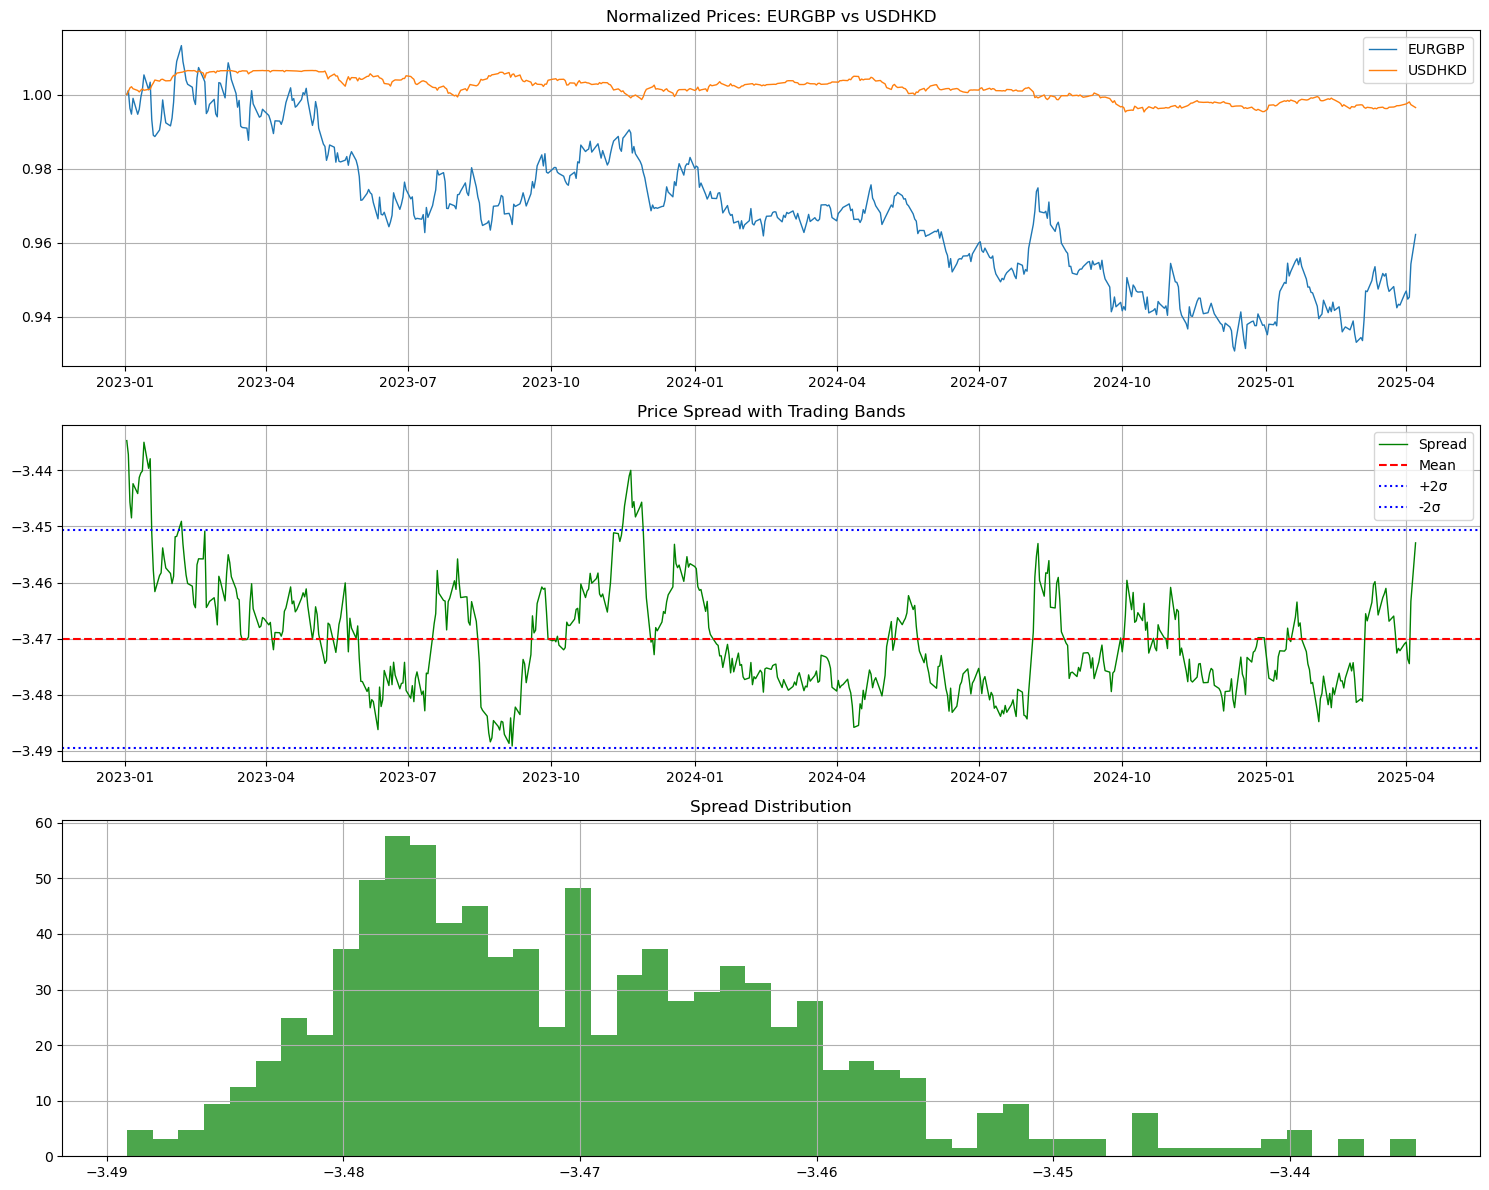

DKKJPY     EURJPY     0.0001    0.1324      0.8


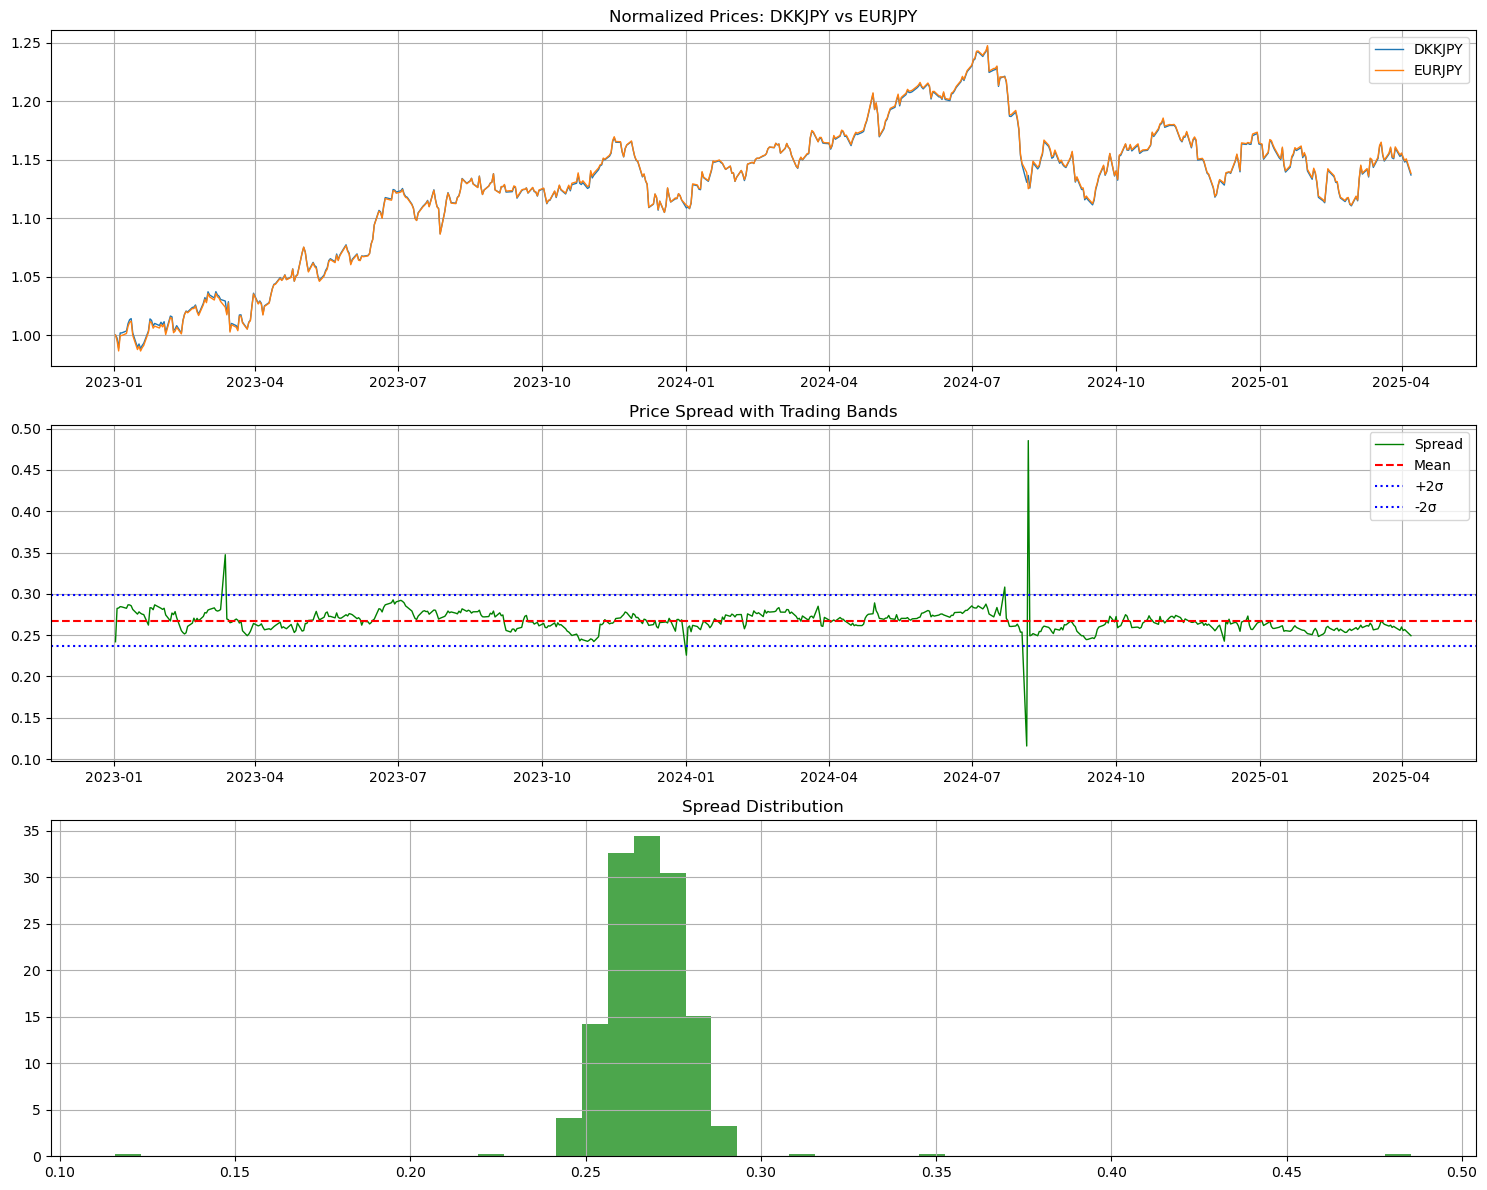

GBPNOK     USDHKD     0.0001    -13.8739      15.4


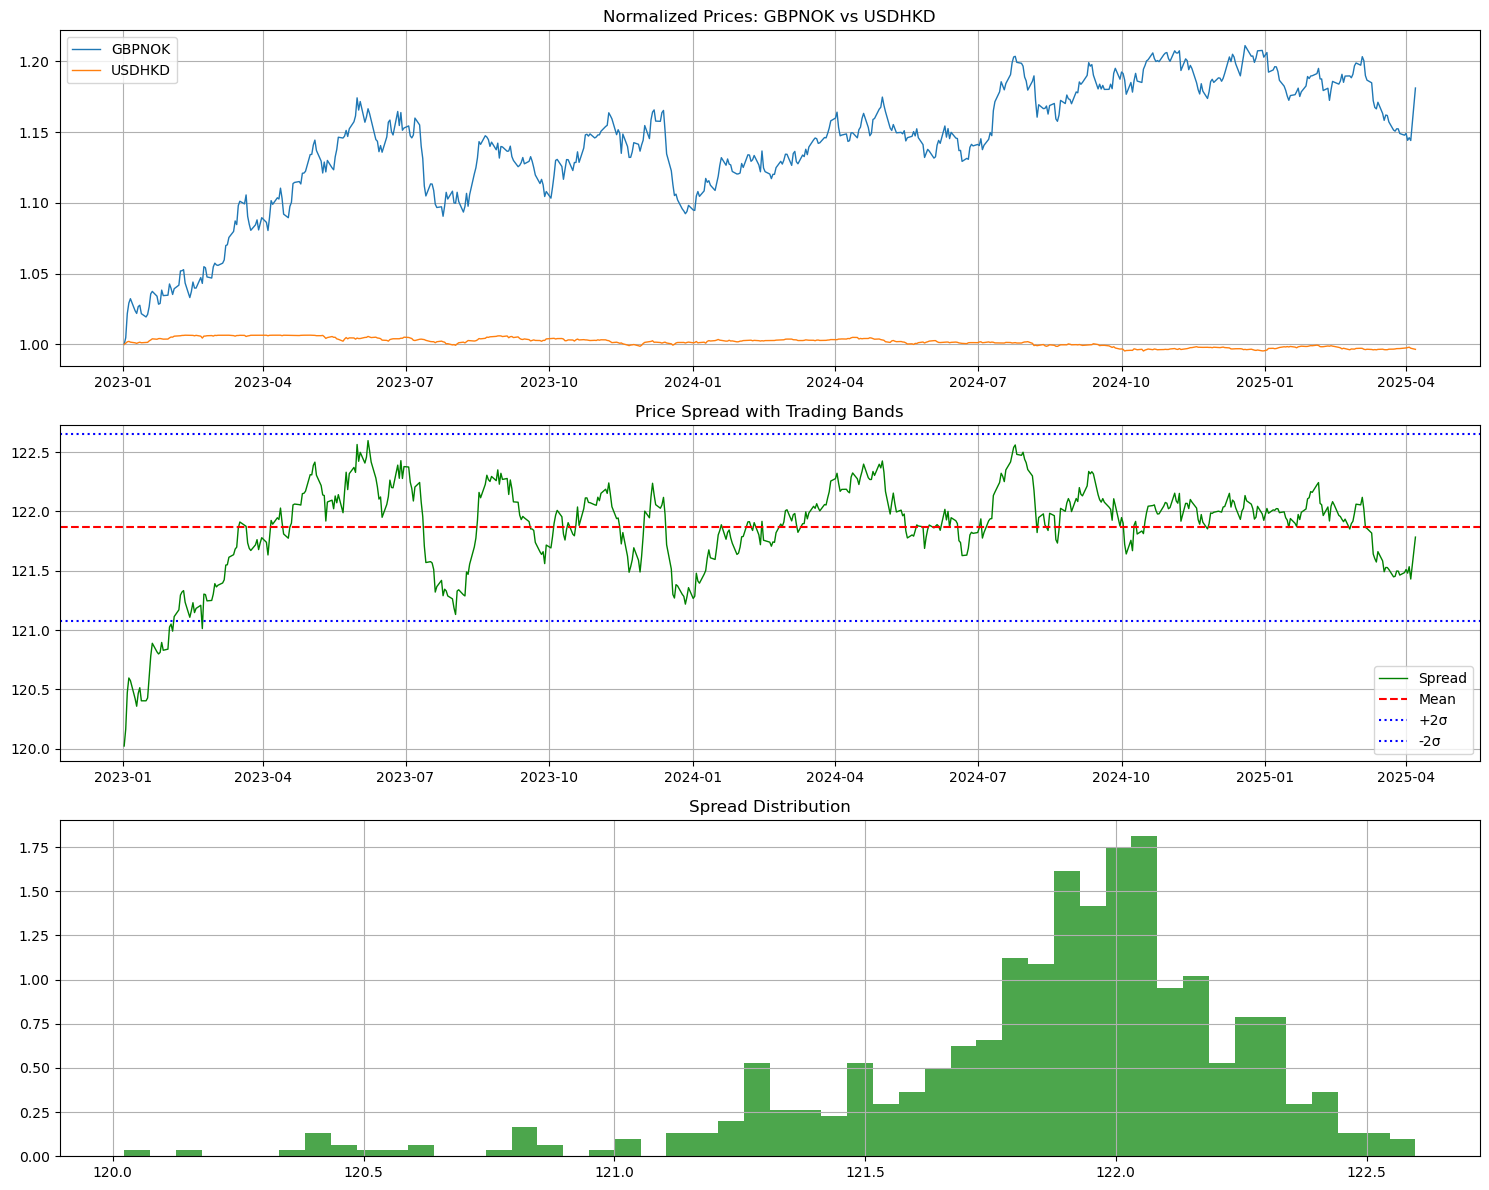

GBPCAD     USDHKD     0.0003    -1.9591      13.1


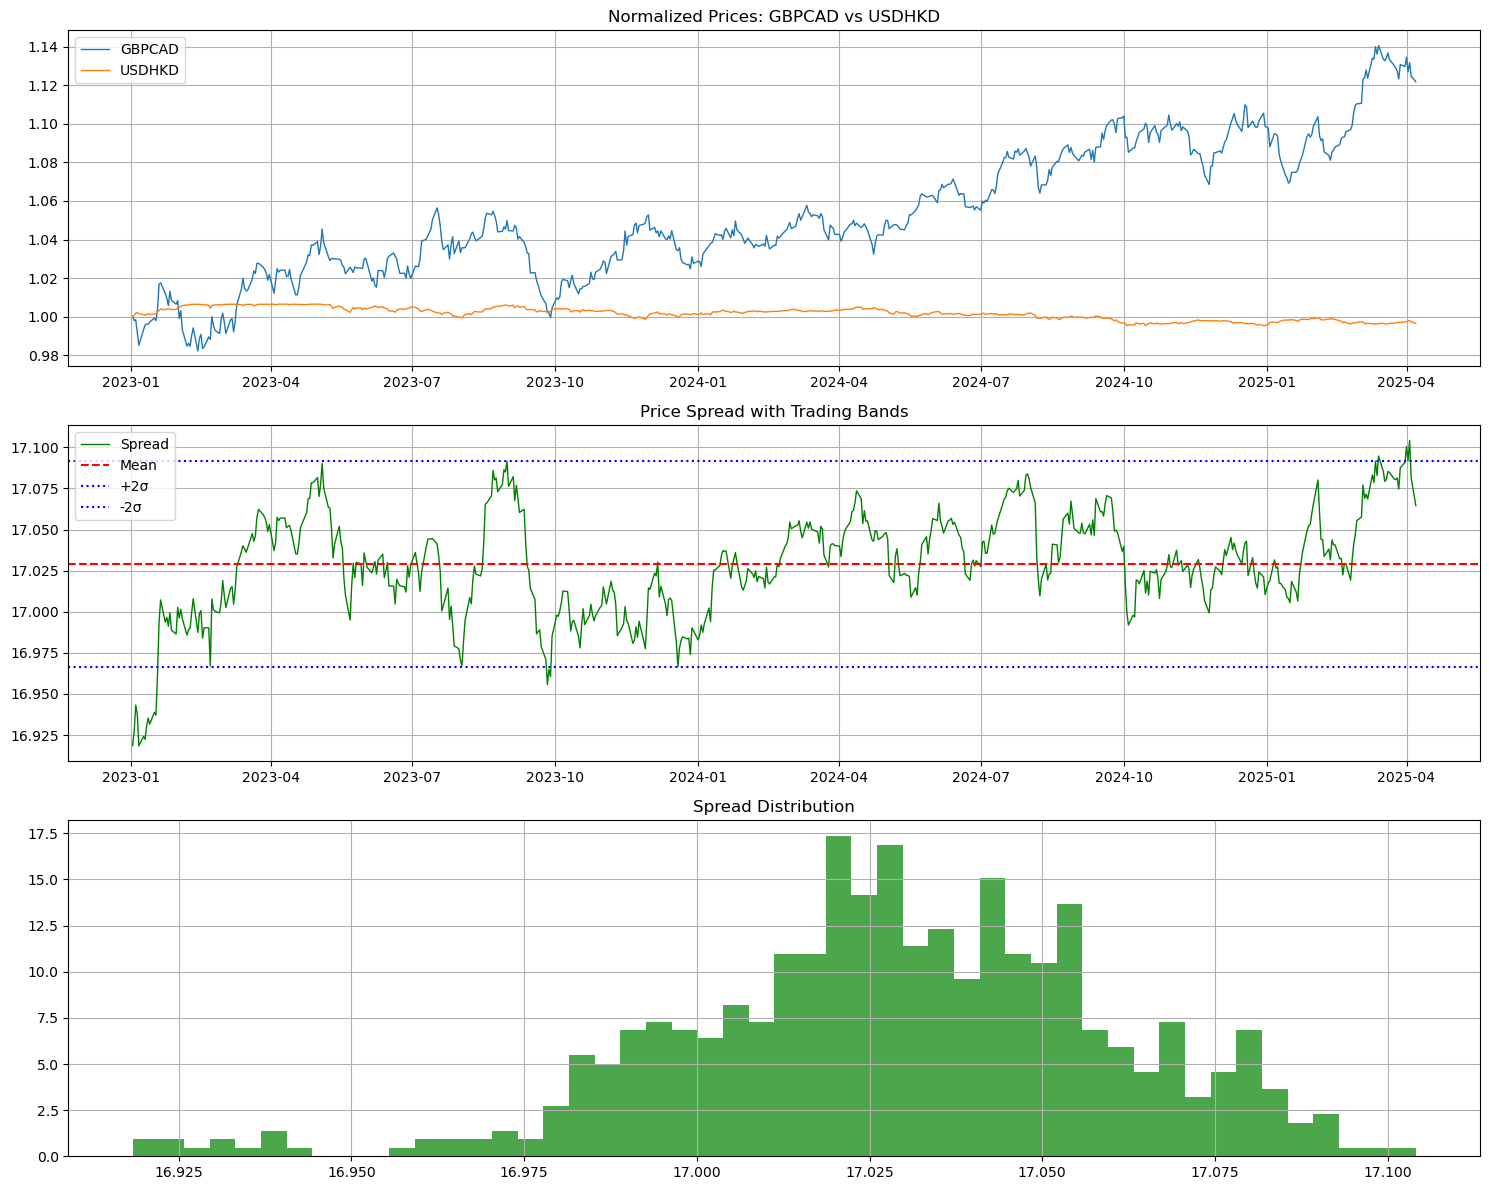

AUDNZD     EURHUF     0.0005    0.0007      11.9
CADCHF     USDHKD     0.0007    0.6843      13.3
SGDJPY     ZARJPY     0.0007    11.5442      14.9
EURGBP     GBPDKK     0.0008    -0.0954      3.8
EURNZD     GBPAUD     0.0012    0.6190      11.7


In [87]:
def main():
    # Set time period
    end_date = datetime.now().strftime('%Y-%m-%d')
    start_date = '2023-01-01'  # One year of data

    print(f"Analyzing forex pairs from {start_date} to {end_date}")

    # Download data
    data = download_forex_data(forex_pairs, start_date, end_date)

    if data is not None:
        # Find significant pairs
        significant_pairs = find_significant_pairs(data)

        # Display results
        print(f"\nFound {len(significant_pairs)} significant pairs (p < 0.05):")
        print("\nTop Cointegrated Pairs:")
        print(f"{'Pair 1':<10} {'Pair 2':<10} {'P-Value':<10} {'Hedge Ratio':<12} {'Half-Life':<10}")
        print("-" * 60)

        # Show top 10 pairs with lowest p-values
        for pair in significant_pairs[:10]:
            print(f"{pair['pair1']:<10} {pair['pair2']:<10} {pair['p_value']:.4f}    {pair['hedge_ratio']:.4f}      {pair['half_life']:.1f}")

            # Create detailed analysis plot for top 5 pairs
            if significant_pairs.index(pair) < 5:
                fig = plot_pair_analysis(data, pair)
                plt.show()

    return pd.DataFrame(significant_pairs)

if __name__ == "__main__":
    main()